In [3]:
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray
from matplotlib import pyplot as plt
import seaborn as sns
import codebase

In [4]:
from codebase import volume_pipeline

In [5]:
res_name = 'Powell'

# Load data

In [6]:
res_name_dict = {'Powell':'glen canyon',
                 'Mead': 'hoover',
                 'Mohave': 'davis bor',
                 'Havasu': 'parker'}

## USBR Data

In [7]:
insitu_data = codebase.load_data.load_formatted_usbr_data(res_name,monthly=True)
print(insitu_data.columns)

Index(['Lake/Reservoir Area [acres]', 'Lake/Reservoir Bank Storage [af]',
       'Lake/Reservoir Change In Storage [af]',
       'Lake/Reservoir Elevation [ft]', 'Lake/Reservoir Evaporation [af]',
       'Lake/Reservoir Inflow - Unregulated [cfs]',
       'Lake/Reservoir Inflow Volume - Unregulated [af]',
       'Lake/Reservoir Inflow [af]', 'Lake/Reservoir Inflow [cfs]',
       'Lake/Reservoir Release - Bypass [af]',
       'Lake/Reservoir Release - Bypass [cfs]',
       'Lake/Reservoir Release - Powerplant [af]',
       'Lake/Reservoir Release - Powerplant [cfs]',
       'Lake/Reservoir Release - Spillway [cfs]',
       'Lake/Reservoir Release - Total [af]',
       'Lake/Reservoir Release - Total [cfs]', 'Lake/Reservoir Storage [af]'],
      dtype='object', name='Variable')


<Axes: xlabel='Datetime (UTC)'>

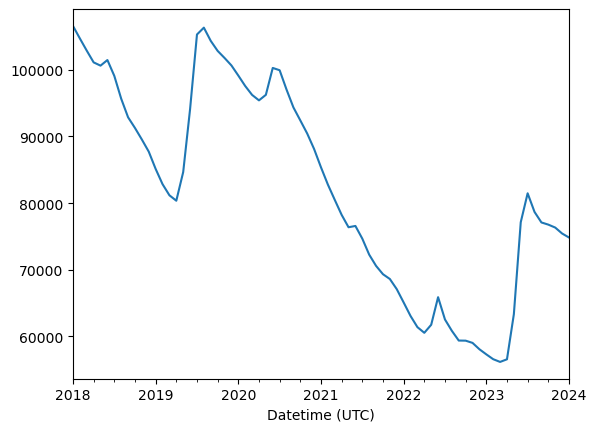

In [8]:
insitu_data['Lake/Reservoir Area [acres]'].plot()

## CYGNSS Data

In [9]:
res_shp = codebase.load_data.load_GRanD()

In [10]:
# Volume pipeline with crs projection
dem_DA , fw_DA = volume_pipeline.create_aligned_DEM_CYGNSS_subsets(res_name_dict[res_name],res_shp,epsg_code=54017)
fw_diff_DA = volume_pipeline.difference_over_time(fw_DA)
change_cond_DA = volume_pipeline.decide_expansion_or_shrinkage_vectorize(fw_diff_DA, input_core_dims = ['y','x'])
test_vol = volume_pipeline.calculate_rough_volume(dem_DA,fw_DA,fw_diff_DA,change_cond_DA,area_kwargs = {'input_core_dims' : [['y','x']], "vectorize": True})

## G-REALM

In [136]:
grealm_data = codebase.load_data.load_grealm_heights(monthly=True)

# Plotting functions

In [11]:
def combine_ref_calc_data(ref_series,calc_series):
    combo_data = pd.concat([ref_series, calc_series],axis=1)
    combo_data.columns = ['Reference','Calculated']
    return combo_data

In [12]:
def calc_min_max_from_df(df,precision=0):
    mn = np.round(df.values.min(),precision)
    mx = np.round(df.values.max(),precision)
    return mn , mx

In [13]:
def square_existing_plot(ax,mn=0,mx=1):
    ax.set_xlim([mn, mx])
    ax.set_ylim([mn, mx])
    ax.set_aspect('equal', adjustable='box')
    ax.grid()
    return ax

In [14]:
def add_best_fit_line_to_existing_plot(ax,lin_regress_vals,mn=0,mx=1):
    x = [mn, mx]
    m = lin_regress_vals['slope'].values
    b = lin_regress_vals['intercept'].values
    y = m*x+b
    ax.plot(x,y)
    return ax

In [15]:
def scatter_with_best_fit(ref_data,calc_data,plt_kwargs={},mnmx_precision=0):
    lin_regress_vals = codebase.time_series_calcs.linregress_wrap(ref_data,calc_data.to_frame())
    print(lin_regress_vals)
    
    combo_data = combine_ref_calc_data(ref_data,calc_data)
    mn , mx = calc_min_max_from_df(combo_data,precision=mnmx_precision)
    
    ax = combo_data.plot(x='Reference',y='Calculated',c=combo_data.index,kind='scatter')
    
    add_best_fit_line_to_existing_plot(ax,lin_regress_vals,mn,mx)
    
    square_existing_plot(ax,mn,mx)
    return combo_data, lin_regress_vals, ax

# Area Calculations

## CYGNSS

In [16]:
cygnss_area_m2 = codebase.area_calcs.CYGNSS_001_area_calculation(fw_DA)

## USBR

In [17]:
# For Lake Powell
usbr_area_ac = insitu_data['Lake/Reservoir Area [acres]']
usbr_area = codebase.utils.convert_from_ac_to_m2(usbr_area_ac)

## Data cleaning

In [18]:
area_cygnss_match , area_usbr_match = codebase.time_series_calcs.intersecting_timeframes(cygnss_area_m2,usbr_area,buffer=1)

In [19]:
def combo_timeframe_df(
    series: list[pd.Series], col_names: list[str] | None = None, buffer: int = 1
) -> pd.DataFrame:
    from codebase.time_series_calcs import intersecting_timeframes
    if col_names is None:
        col_names = []
    sliced_dfs = intersecting_timeframes(*series, buffer=buffer)
    combo_df = pd.concat(sliced_dfs, axis=1)
    try:
        combo_df.index.to_pydatetime()
        combo_df.columns = col_names
    except AttributeError:
        print("Non-datetime indices found. Check combo_timeframe_df function output.")
    return combo_df

In [40]:
area_cols = ['cygnss_area','usbr_area']
area_outputs = codebase.time_series_calcs.combo_timeframe_df([cygnss_area_m2,usbr_area],buffer=0,col_names = area_cols)

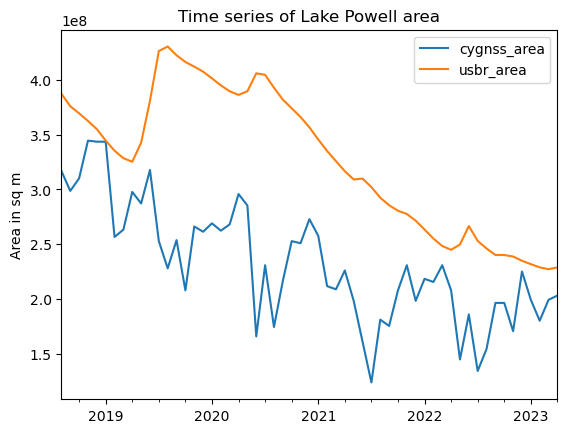

In [41]:
area_outputs.plot()
plt.title('Time series of Lake ' + res_name +' area')
plt.ylabel('Area in sq m');

# Elevation calculations

## CYGNSS

In [42]:
from scipy.stats import norm
norm_fits = volume_pipeline.loop_through_time_series_to_get_fit_params(dem_DA, fw_DA, 1, norm)
norm_elev_m = [val[0] for val in norm_fits]
cygnss_elev_m = pd.Series(index=fw_DA['time'], data = norm_elev_m)

## USBR

In [43]:
usbr_elev_ft = insitu_data['Lake/Reservoir Elevation [ft]']
usbr_elev_m = codebase.utils.convert_from_ft_to_m(usbr_elev_ft)

# elev_calc_norm_match ,elev_ref_match = codebase.time_series_calcs.intersecting_timeframes(norm_elev_series_m,res_ref_elev_m,buffer=0)

## G-REALM

In [154]:
grealm_elev = grealm_data['height_mMSL']

## Data cleaning

In [155]:
elev_cols = ['cygnss_elev','grealm_elev','usbr_elev']
elev_outputs = codebase.time_series_calcs.combo_timeframe_df([cygnss_elev_m,grealm_elev,usbr_elev_m],buffer=0,col_names = elev_cols)

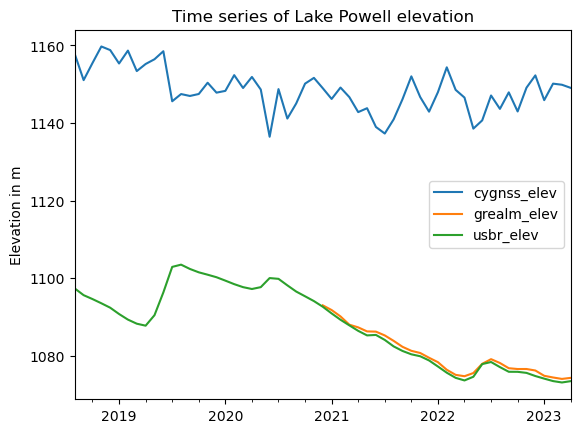

In [156]:
elev_outputs.plot()
plt.title('Time series of Lake ' + res_name+ ' elevation')
plt.ylabel('Elevation in m');

# Area-elevation curves

In [130]:
def x_axis_label_name_change(ax,new_label='',to_existing=True):
    if to_existing:
        x_label = ax.get_xlabel()
        new_label = x_label + new_label
    ax.set_xlabel(new_label)

In [158]:
def x_axis_tick_labels_OoM_change(ax,power):
    x_tick_vals = ax.get_xticks()
    ax.set_xticks(x_tick_vals.tolist())
    new_x_ticks = x_tick_vals / (10**power)
    ax.set_xticklabels(new_x_ticks.astype(int))

In [132]:
def full_x_axis_label_change(ax,power=0,new_label='',to_existing=True):
    x_axis_tick_labels_OoM_change(ax,power)
    x_axis_label_name_change(ax,new_label,to_existing)

full_x_label_change_vec = np.vectorize(full_x_axis_label_change)

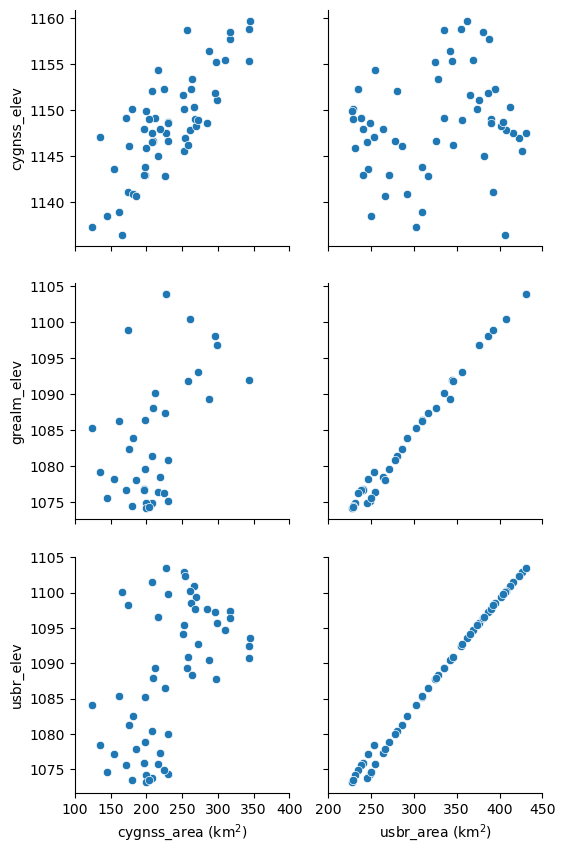

In [173]:
combo_df = pd.concat([area_outputs,elev_outputs],axis=1)

output_plot = sns.pairplot(combo_df, x_vars=area_cols, y_vars=elev_cols,height=3,
                           grid_kws={'layout_pad':2})

full_x_label_change_vec(output_plot.axes,power=6, new_label=' (km$^2$)');

In [ ]:
output_plot.map(x_axis_labels_OoM_change)

/tmp/ipykernel_2866961/1646050177.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_x_ticks.astype(int))


Text(0.5, 0, 'Area (km$^2$)')

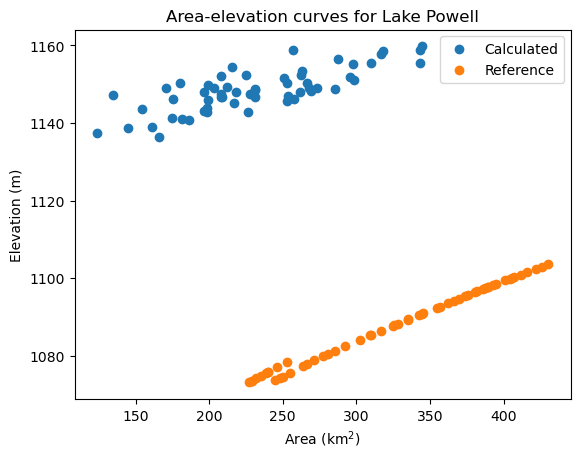

In [23]:
## Comparison of calculated and reference for Lake Powell

data_type = 'Calculated'
plt.scatter(area_outputs[0][data_type],elev_outputs[0][data_type],label=data_type)

data_type = 'Reference'
plt.scatter(area_outputs[0][data_type],elev_outputs[0][data_type],label=data_type)

ax = plt.gca()
x_tick_vals = ax.get_xticks()
new_x_ticks = x_tick_vals / (10**6)
ax.set_xticklabels(new_x_ticks.astype(int))

plt.legend()
plt.title('Area-elevation curves for Lake Powell')
plt.ylabel('Elevation (m)')
plt.xlabel('Area (km$^2$)')


# plt.savefig('../figures/area_elev_comp_LakePowell.png')

## Implement linear regression on CYGNSS-calculated area-elevation curve
See how the linear regression serves for volume estimation.

In [24]:
data_type = 'Calculated'
area_calc = area_outputs[0][data_type] /(10**6)
elev_calc = elev_outputs[0][data_type]

               slope   intercept   r_value p_value   std_err
Calculated  0.080614  1129.81171  0.786473     0.0  0.008536


(1000.0, 1200.0)

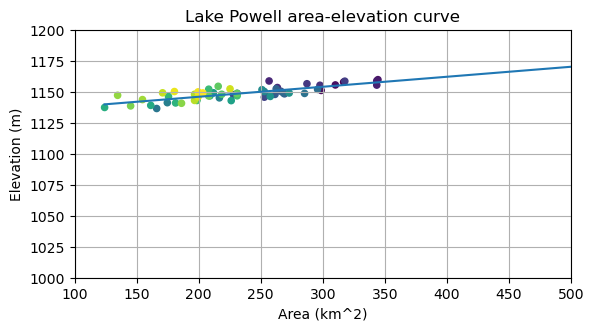

In [25]:
calc_linregress = scatter_with_best_fit(area_calc,elev_calc)

calc_linregress[2].set_xlabel('Area (km^2)')
calc_linregress[2].set_ylabel('Elevation (m)')
calc_linregress[2].set_title('Lake '+res_name + ' area-elevation curve');

subset_dict = {'Powell':([1065,1105],[1135,1165]),
               'Mead'  :([310,340]  ,[380,410]),
               'Havasu':([130,140]  ,[150,180])}

location = res_name
# subset by location
calc_linregress[2].set_xlim([100 , 500])
calc_linregress[2].set_ylim([1000,1200])

In [26]:
calc_linregress[0].shape

(57, 2)